In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import sentencepiece as spm
import tensorflow_hub as hub
import bert

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import unicodedata
import re
import os
import time

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Input, layers, models

In [ ]:
import importlib
import src.attention as attention
importlib.reload(attention);
import src.models as model
importlib.reload(model)
import src.utils as util
importlib.reload(util);

In [ ]:
# Sub-word mapping
target_vocab_size_en = 400
target_vocab_size_fr = 600

spm.SentencePieceTrainer.Train(
    f" --input=data/small_vocab_en --model_type=unigram --hard_vocab_limit=false" +
    f" --model_prefix=data/en --vocab_size={target_vocab_size_en}")
spm.SentencePieceTrainer.Train(
    f" --input=data/small_vocab_fr --model_type=unigram --hard_vocab_limit=false" +
    f" --model_prefix=data/fr --vocab_size={target_vocab_size_fr}")

In [ ]:
# Global data
sp_en = spm.SentencePieceProcessor()
sp_en.Load(os.path.join("data", 'en.model'))

sp_fr = spm.SentencePieceProcessor()
sp_fr.Load(os.path.join("data", 'fr.model'))


file = open(os.path.join('data', 'small_vocab_en'), 'r', encoding='utf-8')
en_text = file.read().split("\n")
file = open(os.path.join('data', 'small_vocab_fr'), 'r', encoding='utf-8')
fr_text = file.read().split("\n")

train_en_X = []
train_fr_X = []
train_fr_Y = []

en_max_len = 0
fr_max_len = 0

vocab_size_en = sp_en.GetPieceSize() -1
vocab_size_fr = sp_fr.GetPieceSize()

In [ ]:
# Bert Tokenizer
BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

In [ ]:
def tokenize_bert(text):
    return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text))

# source_tokenizer = [tokenize_bert(ele) for ele in source]
# source_tensor = source_tokenizer
# print(source_tokenizer[0])

# target_tokenizer = [tokenize_bert(ele) for ele in target]
# target_tensor = target_tokenizer
# print(target_tensor[0])

In [ ]:
# Creating training and validation sets using an 80-20 split
# X_train, X_temp, y_train, y_temp = train_test_split(source_tensor, target_tensor, test_size=0.2, random_state=0)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)

# Show length
# print(len(X_train), len(y_train), len(X_val), len(y_val))
# type(X_train)

In [ ]:
# Create the source and target tokens and post pad them
# Assuming three extra tokens: <end>: #vocab_size_en | #vocab_size_fr,
# <empty>: #vocab_size_en+1 | #vocab_size_fr+1, and <start>: #vocab_size_fr+2

end_token_id_en = vocab_size_en
empty_token_id_en = vocab_size_en + 1
end_token_id_fr = vocab_size_fr
empty_token_id_fr = vocab_size_fr + 1
start_token_id_fr = vocab_size_fr + 2

# The input text only needs two extra tokens while the output needs 3
vocab_size_en = vocab_size_en + 2
vocab_size_fr = vocab_size_fr + 3


for i in range(len(en_text)):
  en_seq = sp_en.EncodeAsIds(en_text[i].strip()) + [end_token_id_en]
  en_max_len = max(en_max_len, len(en_seq))
  train_en_X.append(en_seq)

  fr_seq = sp_fr.EncodeAsIds(fr_text[i].strip()) + [end_token_id_fr]
  fr_max_len = max(fr_max_len, len(fr_seq))
  train_fr_X.append(fr_seq)

# Cleaning up the memory, work with subword
en_text = []
fr_text = []

# Padding all the samples with <empty> token to make them all of the same length
# equal to the longest one
train_en_X = pad_sequences(train_en_X, maxlen=en_max_len,
                           padding="post", value=empty_token_id_en)
# maxlen is fr_max_len+1 since we need to accomodate for <start>
train_fr_X = pad_sequences(train_fr_X, maxlen=fr_max_len+1,
                           padding="post", value=empty_token_id_fr)

# Converting the train_fr_Y to a one-hot vector needed by the training phase as
# the output
train_fr_Y = to_categorical(train_fr_X, num_classes=vocab_size_fr)

# Moving the last <empty> to the first position in each input sample
train_fr_X = np.roll(train_fr_X, 1, axis=-1)
# Changing the first token in each input sample to <start>
train_fr_X[:, 0] = start_token_id_fr

fr_max_len = fr_max_len + 1

In [ ]:
# print ("Input Language; index to word mapping")
# util.convert(source_tokenizer, X_train[0])
# print ()
# print ("Target Language; index to word mapping")
# util.convert(target_tokenizer, y_train[0])

In [ ]:
hidden_dim = 128
checkpoint_dir = 'save'

# Encoder input (English)
input_en = Input(batch_shape=(None, en_max_len), name='input_en')

# English embedding layer
embedding_en = layers.Embedding(vocab_size_en, hidden_dim, name='embedding_en')
embedded_en = embedding_en(input_en)

# Encoder RNN (LSTM) layer
encoder_lstm = layers.Bidirectional(
                  layers.LSTM(hidden_dim,
                              return_sequences=True, return_state=True),
                  name="encoder_lstm")
(encoded_en,
  forward_h_en, forward_c_en,
  backward_h_en, backward_c_en) = encoder_lstm(embedded_en)

In [ ]:
# Decoder input (French)
input_fr = Input(batch_shape=(None, None), name='input_fr')

# English embedding layer
embedding_fr = layers.Embedding(vocab_size_fr, hidden_dim, name='embedding_fr')
embedded_fr = embedding_fr(input_fr)

state_h_en = layers.concatenate([forward_h_en, backward_h_en])
state_c_en = layers.concatenate([forward_c_en, backward_c_en])

# Decoder RNN (LSTM) layer
decoder_lstm = layers.LSTM(hidden_dim * 2, return_sequences=True,
                           return_state=True, name="decoder_lstm")
(encoded_fr,
  forward_h_fr, forward_c_fr) = decoder_lstm(embedded_fr,
                 initial_state=[state_h_en, state_c_en])

In [ ]:
# Attention layer
attention_layer = attention.AttentionLayer(name='attention_layer')
attention_out, attention_states = attention_layer({"values": encoded_en,
                                                   "query": encoded_fr})

# Concatenating the decoder output with attention output
rnn_output = layers.concatenate([encoded_fr, attention_out], name="rnn_output")

# Dense layer
dense_layer0 = layers.Dense(2048, activation='relu', name='dense_0')
dl0 = dense_layer0(rnn_output)

dense_layer1 = layers.Dense(1024, activation='relu', name='dense_1')
dl1 = dense_layer1(dl0)

dense_layer2 = layers.Dense(512, activation='relu', name='dense_2')
dl2 = dense_layer2(dl1)

dl2 = layers.Dropout(0.4)(dl2)

dense_layer3 = layers.Dense(vocab_size_fr, activation='softmax', name='dense_3')
dense_output = dense_layer3(dl2)

In [ ]:
# Train model
training_model = models.Model([input_en, input_fr], dense_output)
training_model.summary()

training_model.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=[model.MaskedCategoricalAccuracy(empty_token_id_fr),
                                model.ExactMatchedAccuracy(empty_token_id_fr)])

# Generative models
encoder_model = models.Model([input_en],
                             [encoded_en,
                              state_h_en, state_c_en])
encoder_model.summary()


# The decoder model, to generate the French tokens (in integer form)
input_h = layers.Input(batch_shape=(None, hidden_dim * 2),
                       name='input_h')
input_c = layers.Input(batch_shape=(None, hidden_dim * 2),
                       name='input_c')

(decoder_output,
  output_h,
  output_c) = decoder_lstm(embedded_fr,
                           initial_state=[input_h, input_c])

input_encoded_en = layers.Input(batch_shape=(None, en_max_len, hidden_dim * 2),
                                name='input_encoded_en')

attention_out, attention_state = attention_layer({"values": input_encoded_en,
                                                  "query": decoder_output})

generative_output = layers.concatenate([decoder_output,
                                        attention_out],
                                       name="generative_output")

g0 = dense_layer0(generative_output)
g1 = dense_layer1(g0)
g2 = dense_layer2(g1)
dense_output = dense_layer3(g2)

decoder_model = models.Model([input_encoded_en, input_fr,
                              input_h, input_c],
                             [dense_output, attention_state,
                              output_h, output_c])
decoder_model.summary()

In [ ]:
# Training
from tensorflow.keras.callbacks import EarlyStopping
EPOCHS = 200
BATCH_SIZE = 64

pocket = EarlyStopping(monitor='val_exact_matched_accuracy', min_delta=0.001,
                       patience=10, verbose=1, mode='max',
                       restore_best_weights = True)

history = training_model.fit(x=[train_en_X, train_fr_X], y=train_fr_Y, batch_size=786,
                             epochs=100, verbose=1, validation_split=0.3, shuffle=True,
                             workers=5, use_multiprocessing=True, callbacks=[pocket])

training_model.save_weights(os.path.join(checkpoint_dir, "nmt.h5"))

In [24]:
# Restoring the latest checkpoint in checkpoint_dir
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
training_model.load_weights(os.path.join(checkpoint_dir, "nmt.h5"))

In [ ]:
# Evaluate
util.plot_training(history)

results = training_model.evaluate(x=[train_en_X, train_fr_X], y=train_fr_Y,
                                  batch_size=786, verbose=1,
                                  workers=1, use_multiprocessing=False)

print('Test loss:', results[0])
print('Test masked categorical accuracy:', results[1])
print('Test exact matched accuracy:', results[2])

In [28]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import math
import sys

# The input English string
#english_string = "the united states is never freezing during november , but the united states is sometimes rainy in winter ."
english_string = "she is going to work."

# First, let's tokenize the Eglish string, then pad it
english_tokens = sp_en.EncodeAsIds(english_string.strip()) + [end_token_id_en]
english_tokens = pad_sequences([english_tokens], maxlen=en_max_len,
                               padding="post", value=empty_token_id_en)

# The encoder, we only need to use it once per each English string
(encoded_en_test, state_h_en_test, state_c_en_test) = encoder_model.predict(english_tokens)

# In order to find a better translation, we are using Beam search
beam_search_list = [{
  "decoder_input": {
    "input_encoded_en": encoded_en_test,
    "input_fr": np.array([[start_token_id_fr]]),
    "input_h": state_h_en_test,
    "input_c": state_c_en_test
  },
  "score": 0.0,
  "parent_node": None,
  "depth": 0,
  "attention_weights": None,
}]
ended_branches = []

beam_size = 10

# We are generating up to fr_max_len tokens
for i in range(fr_max_len):
  new_beam_candidates = []
  # Predict the next token for each member of the list
  for beam in beam_search_list:
    # Use the decoder to predict the next token using the previously
    # predicted token
    (output,
      attention_out,
      state_h_en_test,
      state_c_en_test) = decoder_model.predict(beam["decoder_input"])
    # Find the top beam_size candidates
    top_k = np.argpartition(output[0, 0, :], -beam_size)[-beam_size:]
    # For each candidate, put it in the list to predict the next token for it
    for k in top_k:
      if output[0, 0, k].item() > 0.0:
        log_k = math.log(output[0, 0, k].item())
      else:
        log_k = -sys.float_info.max

      if k == end_token_id_fr:
        ended_branches.append({
          "decoder_input": {
            "input_encoded_en": encoded_en_test,
            "input_fr": np.array([[k]]),
            "input_h": state_h_en_test,
            "input_c": state_c_en_test,
          },
          "score": beam["score"] + log_k,
          "parent_node": beam,
          "depth": beam["depth"] + 1,
          "attention_weights": attention_out,
        })
      else:
        new_beam_candidates.append({
          "decoder_input": {
            "input_encoded_en": encoded_en_test,
            "input_fr": np.array([[k]]),
            "input_h": state_h_en_test,
            "input_c": state_c_en_test,
          },
          "score": beam["score"] + log_k,
          "parent_node": beam,
          "depth": beam["depth"] + 1,
          "attention_weights": attention_out,
        })

  # Keeping only the top beam_size in the list
  beam_search_list = sorted(new_beam_candidates,
                            key=lambda b: b["score"],
                            reverse=True)[0:beam_size]

# Now that we are done with our beam search, let's take the best score and
# detokenize it
beam_node = sorted(beam_search_list + ended_branches,
                   key=lambda b: b["score"] / b["depth"],
                   reverse=True)[0]

# Trace the best beam back to the parent node
all_french_tokens = []
attention_weights = []
while beam_node["parent_node"] is not None:
    all_french_tokens.append(
        beam_node["decoder_input"]["input_fr"][0, 0].item())
    attention_weights.append(beam_node["attention_weights"])
    beam_node = beam_node["parent_node"]

# Traced from tail to head, reserve the order to correct order
all_french_tokens.reverse()
attention_weights.reverse()

# If there's any token out of the vocab, exclude it. This includes `<end>`,
# `<empty>`, and <start> tokens
french_tokens = [t for t in all_french_tokens if t < sp_fr.get_piece_size()]

# Voila!
french_string = sp_fr.DecodeIds(french_tokens)

print("The input English string: ", english_string)
print("The output French string: ", french_string)

The input English string:  she is going to work.
The output French string:  selle est vo mef'sune plu  aimé  s .


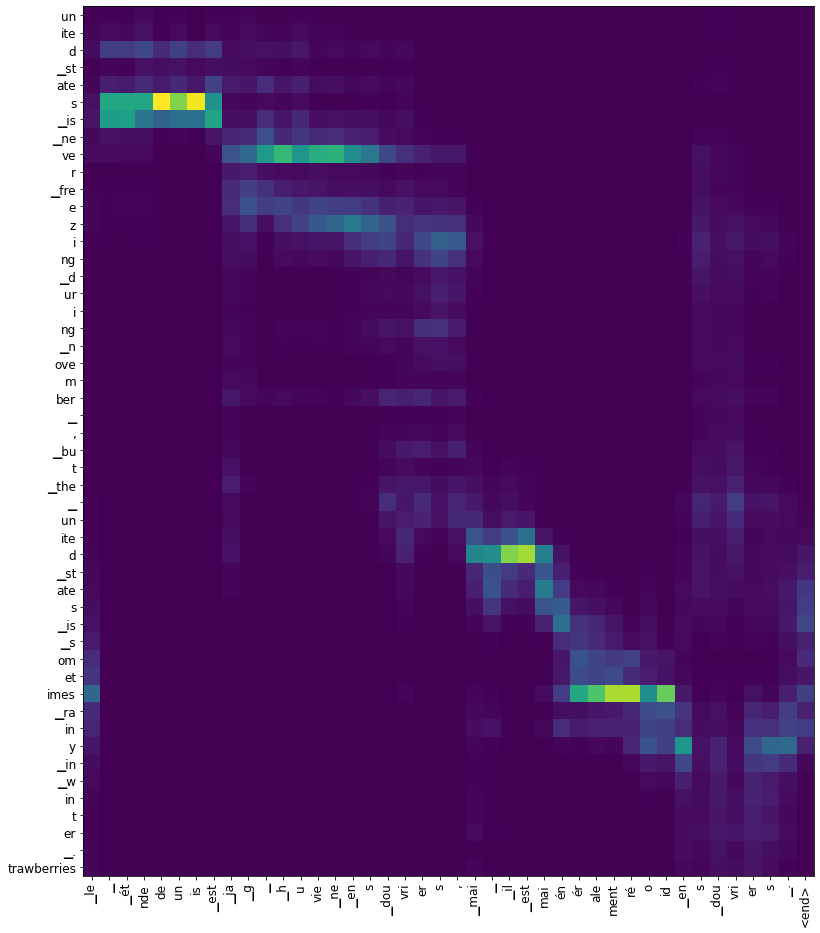

In [26]:
import matplotlib.pyplot as plt

# Plotting the alignment matrix
attention_mat = []
for attn in attention_weights:
  attention_mat.append(attn.reshape(-1))

# We want to have the English tokens on the left axis, so we need to
# trasponse the matrix over the diagonal running from upper right to lower left
attention_mat = np.flipud(np.transpose(np.flipud(attention_mat)))

fig, ax = plt.subplots(figsize=(16, 16))
ax.imshow(attention_mat)

ax.set_xticks(np.arange(attention_mat.shape[1]))
ax.set_yticks(np.arange(attention_mat.shape[0]))

def map_en_special_tokens(t):
    switcher = {}
    switcher[end_token_id_en] = "<end>"
    switcher[empty_token_id_en] = "<empty>"
    return switcher.get(t, "<unknown>")

def map_fr_special_tokens(t):
    switcher = {}
    switcher[end_token_id_fr] = "<end>"
    switcher[empty_token_id_fr] = "<empty>"
    switcher[start_token_id_fr] = "<start>"
    return switcher.get(t, "<unknown>")

ax.set_xticklabels([sp_fr.IdToPiece(t)
                    if t < sp_fr.get_piece_size() else map_fr_special_tokens(t)
                    for t in all_french_tokens])
ax.set_yticklabels([sp_en.IdToPiece(t)
                    if t < sp_en.get_piece_size() else map_en_special_tokens(t)
                    for t in english_tokens[0].tolist()])

ax.tick_params(labelsize=12)
ax.tick_params(axis='x', labelrotation=90)

plt.show()

In [ ]:
# translate(u'I am going to work.')
# translate(u'The project is super hard.')
# util.translate(u'She works at home.', units, max_target_length, max_source_length, encoder, decoder, source_tokenizer, target_tokenizer)
